In [15]:
# Common imports
import os
import numpy as np
import cv2
import pandas as pd
from skimage.feature import hog
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import concurrent.futures
import pickle

# Paths to the folders containing the images and height arrays
top_image_folder = 'brispi/top_images'
height_folder = 'height_arrays'
output_dir = 'demo_results'

# Best hyperparameters
best_params = {
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
}

# Common Functions
def split_filename(filename):
    """
    Splits a filename into its components.

    Args:
        filename (str): The filename to split.

    Returns:
        tuple: Components of the filename.
    """
    parts = filename.split("_")
    base = "_".join(parts[:5])
    z = "_".join(parts[5:7])
    y_m_d_h = "_".join(parts[8:12])
    y_m_d, h = y_m_d_h.split("_")[0:3], y_m_d_h.split("_")[-1]
    min_sec = "_".join(parts[12:])
    return base, z, y_m_d, min_sec, h

def get_files_and_splits(directory):
    """
    Retrieves files from a directory and splits their filenames.

    Args:
        directory (str): The directory to retrieve files from.

    Returns:
        list: List of tuples containing split filename components.
    """
    files = os.listdir(directory)
    return [split_filename(f) + (f,) for f in files]

def hours_within_threshold(hour1, hour2, threshold=1):
    """
    Checks if two hours are within a specified threshold.

    Args:
        hour1 (int): First hour.
        hour2 (int): Second hour.
        threshold (int): Threshold value.

    Returns:
        bool: True if hours are within threshold, False otherwise.
    """
    hour1, hour2 = int(hour1), int(hour2)
    return (hour1 == hour2) or ((hour1 + 1) % 24 == hour2) or ((hour1 - 1) % 24 == hour2)

def calculate_means(height_array, num_parts=5):
    """
    Calculates mean values for parts of a height array.

    Args:
        height_array (numpy.ndarray): Height array.
        num_parts (int): Number of parts to divide the array into.

    Returns:
        list: List of mean values for each part.
    """
    part_size = len(height_array) // num_parts
    means = [np.mean(height_array[i * part_size:(i + 1) * part_size]) for i in range(num_parts)]
    return means

def load_image_and_height(match, img_size=224, num_segments=224):
    """
    Loads an image and its corresponding height array, preprocesses them.

    Args:
        match (tuple): Tuple containing image and height array filenames.
        img_size (int): Size to resize the image to.
        num_segments (int): Number of segments to divide the height array into.

    Returns:
        tuple: Preprocessed image and height array.
    """
    top_image_name, height_array_name = match
    img_path = os.path.join(top_image_folder, top_image_name)
    height_path = os.path.join(height_folder, height_array_name)

    img = cv2.imread(img_path)
    if img is None:
        return None, None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.rotate(img, cv2.ROTATE_180)

    height, width = img.shape[:2]
    start_x = (width - 3280) // 2
    start_y = (height - 2464) // 2
    img = img[start_y:start_y + 2464, start_x:start_x + 3280]
    img = cv2.resize(img, (img_size, img_size))

    height_array = np.load(height_path)
    if height_array.size == 0:
        return None, None

    normalized_height_array = height_array / 2464.0
    segment_length = len(normalized_height_array) // num_segments
    avg_height_per_segment = np.array([
        np.mean(normalized_height_array[i * segment_length:(i + 1) * segment_length])
        for i in range(num_segments)
    ])

    return img, avg_height_per_segment

def preprocess_data(matches, img_size=224, num_segments=224):
    """
    Preprocesses data by loading images and height arrays, and extracting features.

    Args:
        matches (list): List of tuples containing matched filenames.
        img_size (int): Size to resize the images to.
        num_segments (int): Number of segments to divide the height arrays into.

    Returns:
        tuple: Arrays of images, height arrays, and matched filenames.
    """
    images, height_arrays, matched_filenames = [], [], []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(lambda match: load_image_and_height(match, img_size, num_segments), matches))

    for match, (img, height_array) in zip(matches, results):
        if img is not None and height_array is not None:
            images.append(img)
            height_arrays.append(height_array)
            matched_filenames.append(match)

    return np.array(images), np.array(height_arrays), matched_filenames

def extract_hog_features(image):
    """
    Extracts Histogram of Oriented Gradients (HOG) features from an image.

    Args:
        image (numpy.ndarray): Image to extract features from.

    Returns:
        tuple: HOG features and HOG image.
    """
    gray_image = (image * 255).astype(np.uint8)
    gray_image = cv2.cvtColor(gray_image, cv2.COLOR_RGB2GRAY)
    fd, hog_image = hog(gray_image, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualize=True)
    return fd, hog_image

def visualize_images(images, filenames, num_samples=5, title="Images"):
    """
    Visualizes a set of images.

    Args:
        images (list): List of images to visualize.
        filenames (list): List of filenames corresponding to the images.
        num_samples (int): Number of images to visualize.
        title (str): Title for the visualization plot.
    """
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        img_path = os.path.join(top_image_folder, filenames[i][0])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.rotate(img, cv2.ROTATE_180)

        height, width = img.shape[:2]
        start_x = (width - 3280) // 2
        start_y = (height - 2464) // 2
        img = img[start_y:start_y + 2464, start_x:start_x + 3280]
        img = cv2.resize(img, (224, 224))

        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def visualize_test_image(test_filenames, index=0):
    """
    Visualizes a test image.

    Args:
        test_filenames (list): List of test filenames.
        index (int): Index of the test image to visualize.
    """
    img_path = os.path.join(top_image_folder, test_filenames[index][0])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.rotate(img, cv2.ROTATE_180)

    height, width = img.shape[:2]
    start_x = (width - 3280) // 2
    start_y = (height - 2464) // 2
    img = img[start_y:start_y + 2464, start_x:start_x + 3280]
    img = cv2.resize(img, (224, 224))

    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Test Image")
    plt.show()

def visualize_test_predictions(test_images, true_heights, predicted_heights, num_samples=1):
    """
    Visualizes test predictions by comparing true and predicted heights.

    Args:
        test_images (list): List of test images.
        true_heights (list): List of true heights.
        predicted_heights (list): List of predicted heights.
        num_samples (int): Number of samples to visualize.
    """
    plt.figure(figsize=(5 * num_samples, 5))
    for i in range(num_samples):
        img = test_images[i]
        true_height = true_heights[i]
        predicted_height = predicted_heights[i]
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY), cmap='gray')
        plt.title(f"True: {np.round(true_height, 2)}\nPred: {np.round(predicted_height, 2)}", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_hog_features(images, hog_images, num_samples=3):
    """
    Visualizes HOG features for a set of images.

    Args:
        images (list): List of images.
        hog_images (list): List of HOG images.
        num_samples (int): Number of samples to visualize.
    """
    plt.figure(figsize=(15, 10))
    selected_indices = np.random.choice(len(images), num_samples, replace=False)
    for i, idx in enumerate(selected_indices):
        img = images[idx]
        hog_img = hog_images[idx]

        plt.subplot(2, num_samples, i + 1)
        plt.imshow(cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY), cmap='gray')
        plt.title(f"Original Image {i+1}")
        plt.axis('off')

        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(hog_img, cmap='gray')
        plt.title(f"HOG Features {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def generate_scatter_plot(y_test, y_pred_test, model_name, model_dir):
    """
    Generates a scatter plot comparing actual and predicted heights.

    Args:
        y_test (numpy.ndarray): Actual heights.
        y_pred_test (numpy.ndarray): Predicted heights.
        model_name (str): Name of the model.
        model_dir (str): Directory to save the scatter plot.
    """
    y_test_flat = y_test.flatten()
    y_pred_test_flat = y_pred_test.flatten()

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_flat, y_pred_test_flat, alpha=0.5, color='b', edgecolors='k')
    plt.title(f'Predicted vs Actual Heights for {model_name}')
    plt.xlabel('Actual Heights')
    plt.ylabel('Predicted Heights')

    plt.xlim([0, 1])
    plt.ylim([0, 1])

    plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=2)  # Diagonal line

    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(model_dir, f'scatter_plot_{model_name}.png'))
    plt.show()

def save_results(model_name, model, X_test, y_test, y_pred_test):
    """
    Saves the trained model, predictions, and evaluation metrics.

    Args:
        model_name (str): Name of the model.
        model (sklearn model): Trained model.
        X_test (numpy.ndarray): Test features.
        y_test (numpy.ndarray): True test targets.
        y_pred_test (numpy.ndarray): Predicted test targets.
    """
    model_dir = os.path.join(output_dir, model_name)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    
    # Save the model
    model_path = os.path.join(model_dir, f'{model_name}_model.pkl')
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    
    # Save predictions
    predictions_path = os.path.join(model_dir, 'predictions.csv')
    pd.DataFrame({'True': y_test.flatten(), 'Predicted': y_pred_test.flatten()}).to_csv(predictions_path, index=False)
    
    # Save metrics
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)
    
    metrics_path = os.path.join(model_dir, 'metrics.txt')
    with open(metrics_path, 'w') as f:
        f.write(f'MSE: {mse:.4f}\n')
        f.write(f'RMSE: {rmse:.4f}\n')
        f.write(f'MAE: {mae:.4f}\n')
        f.write(f'R2: {r2:.4f}\n')
    
    print(f"Results saved to {model_dir}")

    # Save scatter plot
    generate_scatter_plot(y_test, y_pred_test, model_name, model_dir)



Training fold 1...
Fold 1 - MSE: 0.0200, RMSE: 0.1415, MAE: 0.1319, R2: -5530.2689
Training fold 2...
Fold 2 - MSE: 0.0186, RMSE: 0.1364, MAE: 0.1169, R2: -0.4141
Training fold 3...
Fold 3 - MSE: 0.0449, RMSE: 0.2120, MAE: 0.1817, R2: -5044.0902
Training fold 4...


/home/ec2-user/SageMaker/growy-kernel/miniconda/envs/growy_kernel/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Fold 4 - MSE: 0.0024, RMSE: 0.0488, MAE: 0.0374, R2: nan
Training fold 5...


/home/ec2-user/SageMaker/growy-kernel/miniconda/envs/growy_kernel/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Fold 5 - MSE: 0.0027, RMSE: 0.0519, MAE: 0.0420, R2: nan
Mean cross-validation MSE: 0.0177
Training final model on all training data...
Test set MSE: 0.0443
Test set RMSE: 0.2105
Test set MAE: 0.2060
Test set R2: -141.7006
Results saved to demo_results/demo_RF_224_segments


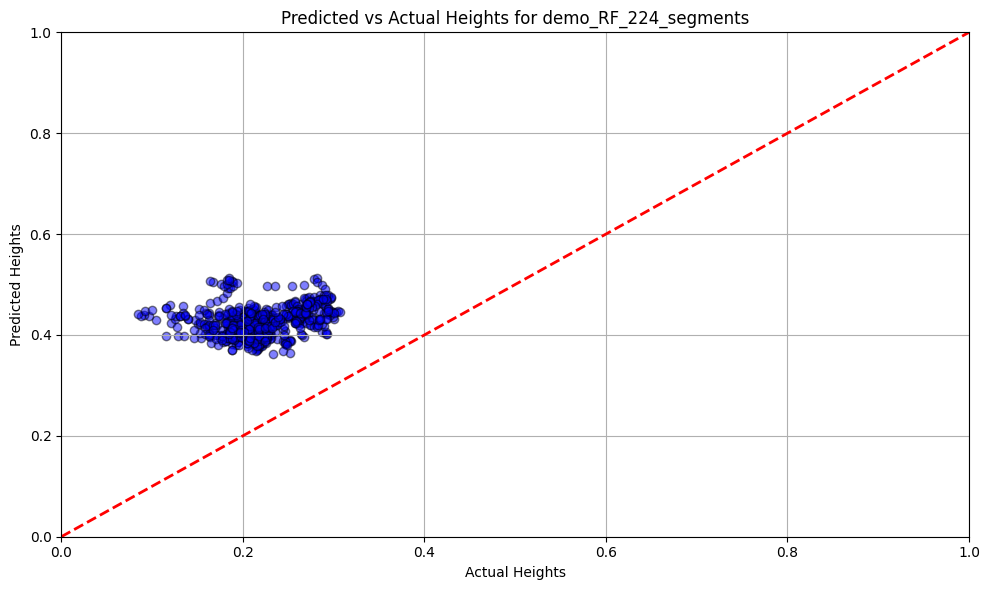

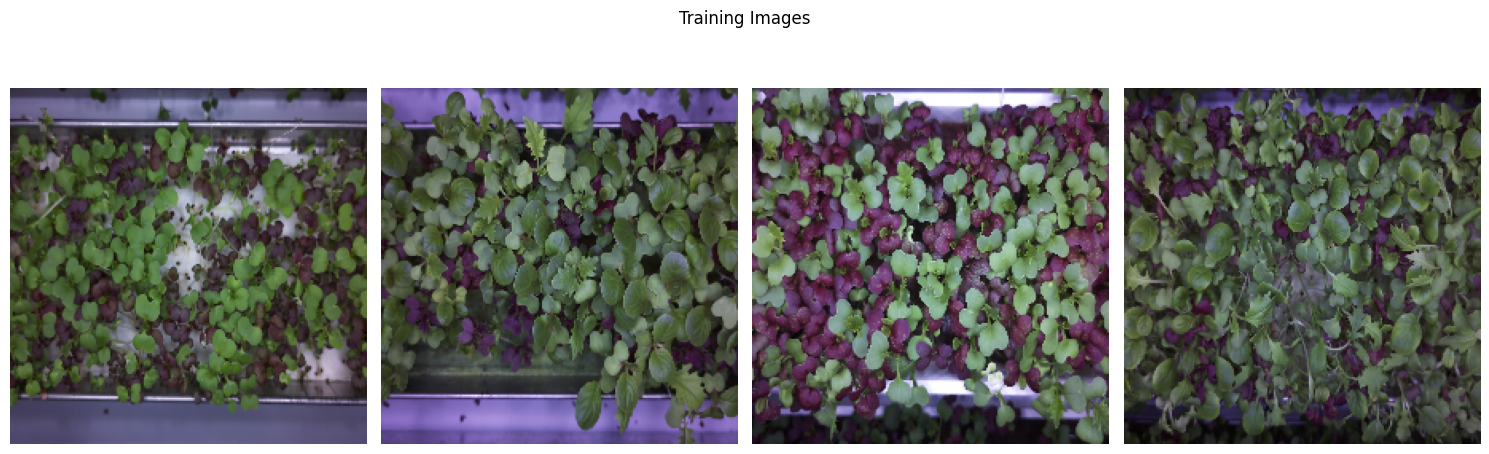

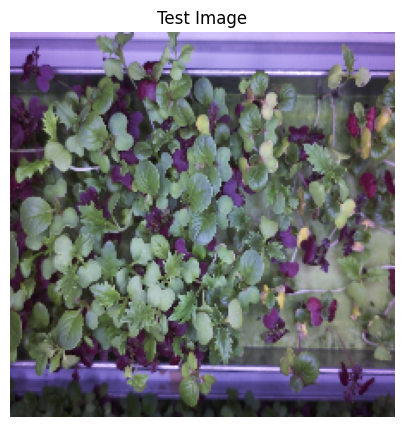

In [16]:
# Cell 1: 224-segment Random Forest model

# Paths and model save path
model_name_224 = 'demo_RF_224_segments'
model_save_path_224 = os.path.join(output_dir, f'{model_name_224}.pkl')

# Get files and splits
image_files = get_files_and_splits(top_image_folder)
array_files = get_files_and_splits(height_folder)

# Match files based on base, y_m_d and hour
matches = [(image[-1], array[-1]) for image in image_files for array in array_files
           if image[0] == array[0] and image[2] == array[2] and hours_within_threshold(image[4], array[4])]

# Load and preprocess data
images, height_arrays, matched_filenames = preprocess_data(matches, img_size=224, num_segments=224)
if len(images) == 0 or len(height_arrays) == 0:
    raise ValueError("No images or height arrays were loaded. Please check the data folder and files.")

images = images / 255.0

# Extract HOG features
hog_features, hog_images = zip(*[extract_hog_features(img) for img in images])
hog_features = np.array(hog_features)

# Split data into training and test sets
X_train, X_test, y_train, y_test, train_filenames, test_filenames = train_test_split(
    hog_features, height_arrays, matched_filenames, test_size=0.2, random_state=42)

# Adjust the number of splits for cross-validation
n_splits = min(5, X_train.shape[0])

# 5-fold cross-validation setup on training data
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
fold = 1
cv_results = []
fold_metrics = []

for train_index, val_index in kf.split(X_train):
    print(f"Training fold {fold}...")
    X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

    model = RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        random_state=42
    )

    model.fit(X_train_cv, y_train_cv)
    y_pred_val = model.predict(X_val_cv)

    mse_val = mean_squared_error(y_val_cv, y_pred_val)
    rmse_val = np.sqrt(mse_val)
    mae_val = mean_absolute_error(y_val_cv, y_pred_val)
    r2_val = r2_score(y_val_cv, y_pred_val)

    print(f"Fold {fold} - MSE: {mse_val:.4f}, RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}, R2: {r2_val:.4f}")

    fold_results = {
        'fold': fold,
        'mse': mse_val,
        'rmse': rmse_val,
        'mae': mae_val,
        'r2': r2_val
    }

    cv_results.append(mse_val)
    fold_metrics.append(fold_results)
    fold += 1

mean_cv_mse = np.mean(cv_results)
print(f"Mean cross-validation MSE: {mean_cv_mse:.4f}")

# Fit final model on all training data
print("Training final model on all training data...")
final_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
final_model.fit(X_train, y_train)

# Evaluate the final model on the test set
y_pred_test = final_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print(f'Test set MSE: {mse_test:.4f}')
print(f'Test set RMSE: {rmse_test:.4f}')
print(f'Test set MAE: {mae_test:.4f}')
print(f'Test set R2: {r2_test:.4f}')

# Save results
save_results(model_name_224, final_model, X_test, y_test, y_pred_test)

# Visualization
visualize_images(images[:4], train_filenames[:4], num_samples=4, title="Training Images")
visualize_test_image(test_filenames, index=0)

Training fold 1...
Fold 1 - MSE: 0.0210, RMSE: 0.1450, MAE: 0.1357, R2: -83.4713
Training fold 2...
Fold 2 - MSE: 0.0164, RMSE: 0.1282, MAE: 0.1102, R2: -0.2146
Training fold 3...
Fold 3 - MSE: 0.0436, RMSE: 0.2089, MAE: 0.1858, R2: -10.5721
Training fold 4...


/home/ec2-user/SageMaker/growy-kernel/miniconda/envs/growy_kernel/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Fold 4 - MSE: 0.0013, RMSE: 0.0357, MAE: 0.0301, R2: nan
Training fold 5...


/home/ec2-user/SageMaker/growy-kernel/miniconda/envs/growy_kernel/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Fold 5 - MSE: 0.0003, RMSE: 0.0186, MAE: 0.0177, R2: nan
Mean cross-validation MSE: 0.0165
Training final model on all training data...
Test set MSE: 0.0423
Test set RMSE: 0.2057
Test set MAE: 0.2042
Test set R2: -90.3437
Results saved to demo_results/demo_RF_5split


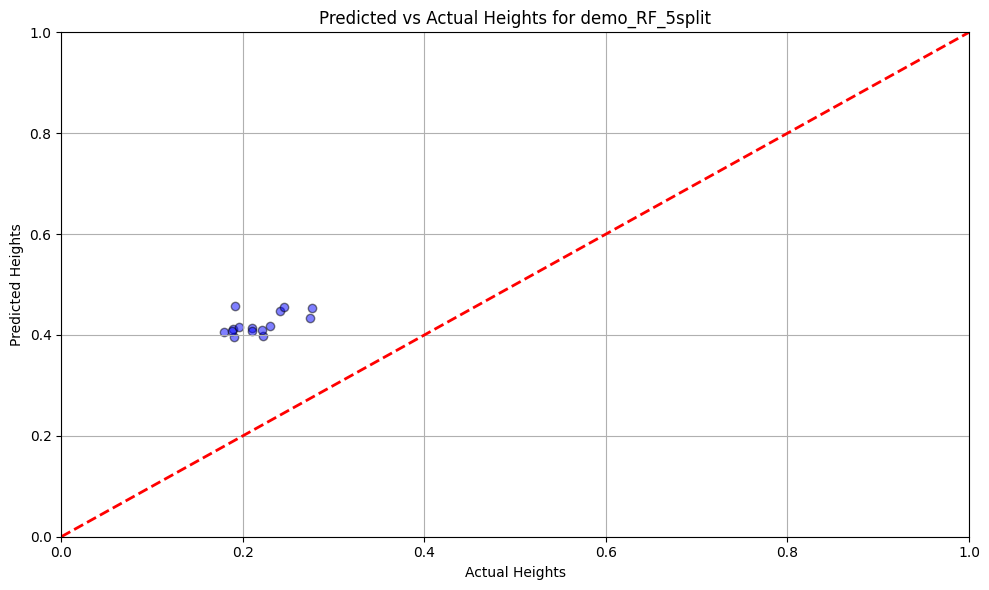

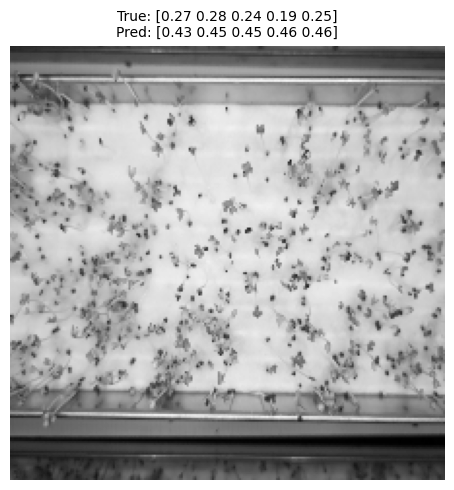

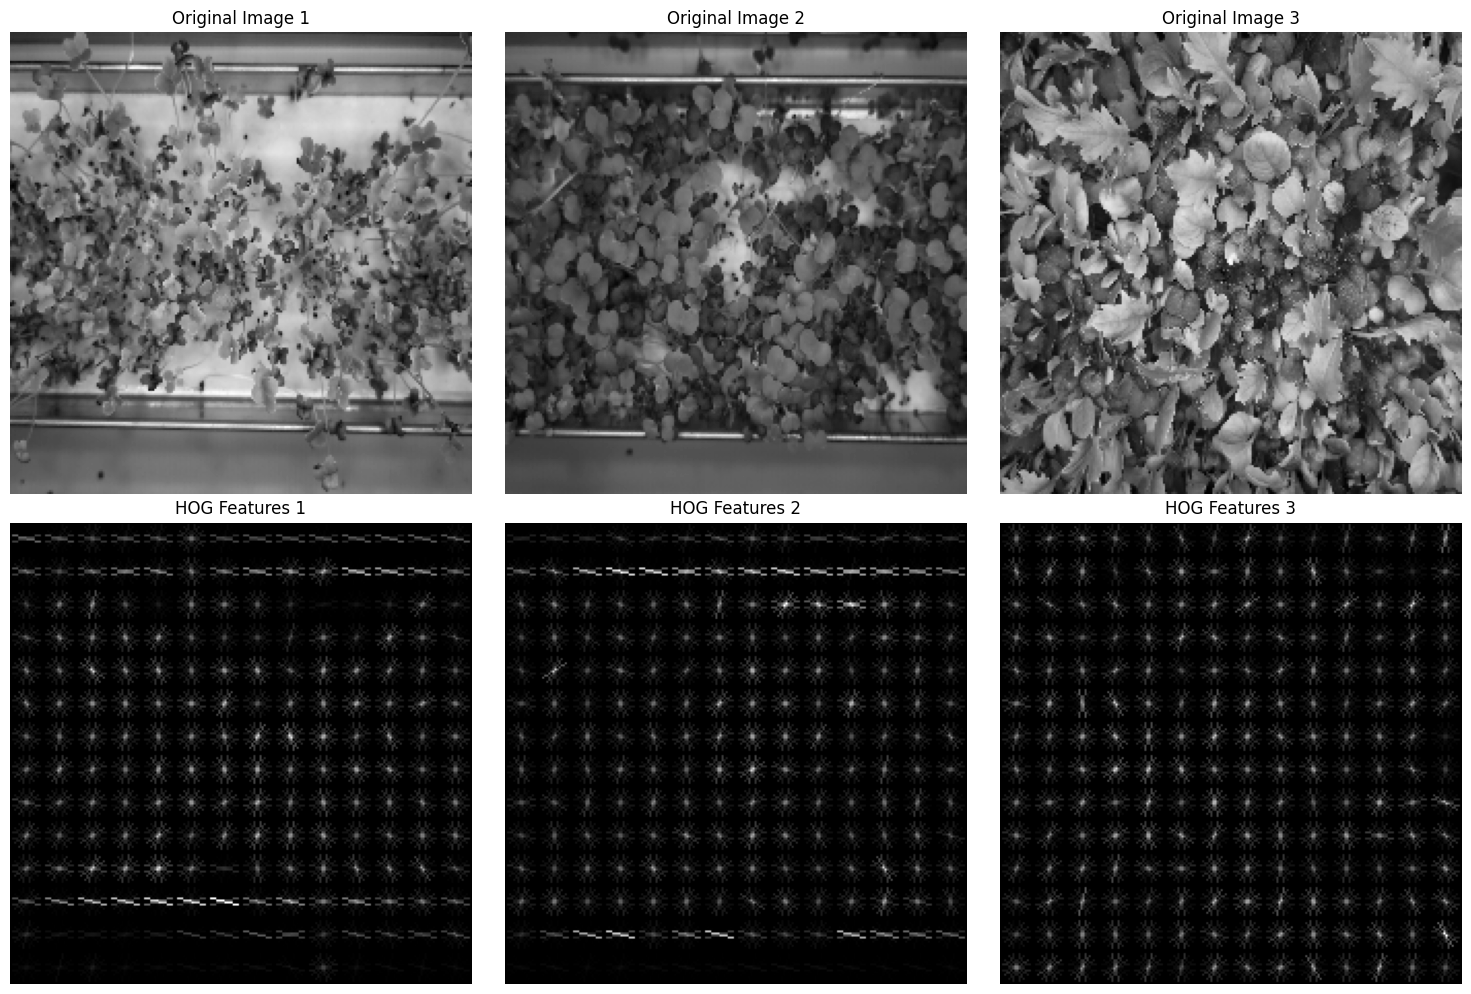

In [22]:
# Cell 2: 5-split Random Forest model

# Paths and model save path
model_name_5split = 'demo_RF_5split'
model_save_path_5split = os.path.join(output_dir, f'{model_name_5split}.pkl')

# Get files and splits
image_files = get_files_and_splits(top_image_folder)
array_files = get_files_and_splits(height_folder)

# Match files based on base, y_m_d and hour
matches = [(image[-1], array[-1]) for image in image_files for array in array_files
           if image[0] == array[0] and image[2] == array[2] and hours_within_threshold(image[4], array[4])]

# Load and preprocess data
images, height_arrays, matched_filenames = preprocess_data(matches, img_size=224, num_segments=5)
if len(images) == 0 or len(height_arrays) == 0:
    raise ValueError("No images or height arrays were loaded. Please check the data folder and files.")

images = images / 255.0

# Extract HOG features
hog_features, hog_images = zip(*[extract_hog_features(img) for img in images])
hog_features = np.array(hog_features)

# Split data into training and test sets
X_train, X_test, y_train, y_test, train_filenames, test_filenames = train_test_split(
    hog_features, height_arrays, matched_filenames, test_size=0.2, random_state=42)

# Adjust the number of splits for cross-validation
n_splits = min(5, X_train.shape[0])

# 5-fold cross-validation setup on training data
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
fold = 1
cv_results = []
fold_metrics = []

for train_index, val_index in kf.split(X_train):
    print(f"Training fold {fold}...")
    X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

    model = RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        random_state=42
    )

    model.fit(X_train_cv, y_train_cv)
    y_pred_val = model.predict(X_val_cv)

    mse_val = mean_squared_error(y_val_cv, y_pred_val)
    rmse_val = np.sqrt(mse_val)
    mae_val = mean_absolute_error(y_val_cv, y_pred_val)
    r2_val = r2_score(y_val_cv, y_pred_val)

    fold_results = {
        'fold': fold,
        'mse': mse_val,
        'rmse': rmse_val,
        'mae': mae_val,
        'r2': r2_val
    }

    cv_results.append(mse_val)
    fold_metrics.append(fold_results)

    print(f"Fold {fold} - MSE: {mse_val:.4f}, RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}, R2: {r2_val:.4f}")
    fold += 1

mean_cv_mse = np.mean(cv_results)
print(f"Mean cross-validation MSE: {mean_cv_mse:.4f}")

# Fit final model on all training data
print("Training final model on all training data...")
final_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
final_model.fit(X_train, y_train)

# Evaluate the final model on the test set
y_pred_test = final_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print(f'Test set MSE: {mse_test:.4f}')
print(f'Test set RMSE: {rmse_test:.4f}')
print(f'Test set MAE: {mae_test:.4f}')
print(f'Test set R2: {r2_test:.4f}')

# Save results
save_results(model_name_5split, final_model, X_test, y_test, y_pred_test)

# Get the corresponding test image and true height
test_images = [images[i] for i in np.where(np.isin(matched_filenames, test_filenames))[0]]
true_test_heights = y_test

# Visualization
visualize_test_predictions(test_images, true_test_heights, y_pred_test, num_samples=1)
visualize_hog_features(images, hog_images, num_samples=3)

Class distribution (side data): {0: 5, 1: 3, 2: 3}
Class distribution (training data): {0: 4, 1: 2, 2: 2}
Class distribution (test data): {0: 1, 1: 1, 2: 1}
Training fold 1...
Fold 1 accuracy: 0.3333
Training fold 2...


/home/ec2-user/SageMaker/growy-kernel/miniconda/envs/growy_kernel/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Fold 2 accuracy: 0.0000
Training fold 3...
Fold 3 accuracy: 0.5000
Mean cross-validation accuracy: 0.2778
Test set accuracy: 0.3333
Confusion Matrix:
[[1 0 0]
 [1 0 0]
 [1 0 0]]
Classification Report:
              precision    recall  f1-score   support

       Short       0.33      1.00      0.50         1
      Medium       0.00      0.00      0.00         1
        Tall       0.00      0.00      0.00         1

    accuracy                           0.33         3
   macro avg       0.11      0.33      0.17         3
weighted avg       0.11      0.33      0.17         3



/home/ec2-user/SageMaker/growy-kernel/miniconda/envs/growy_kernel/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/SageMaker/growy-kernel/miniconda/envs/growy_kernel/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/SageMaker/growy-kernel/miniconda/envs/growy_kernel/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

<Figure size 1000x700 with 0 Axes>

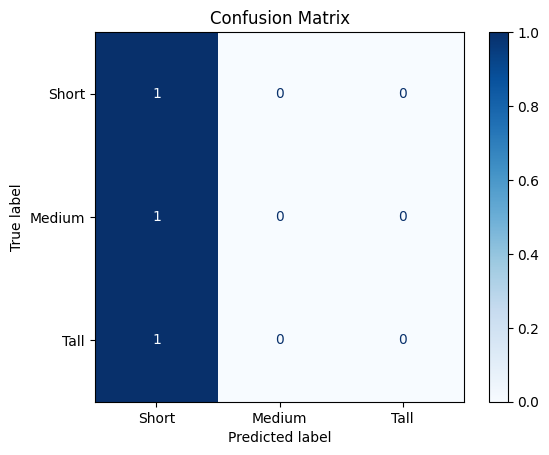

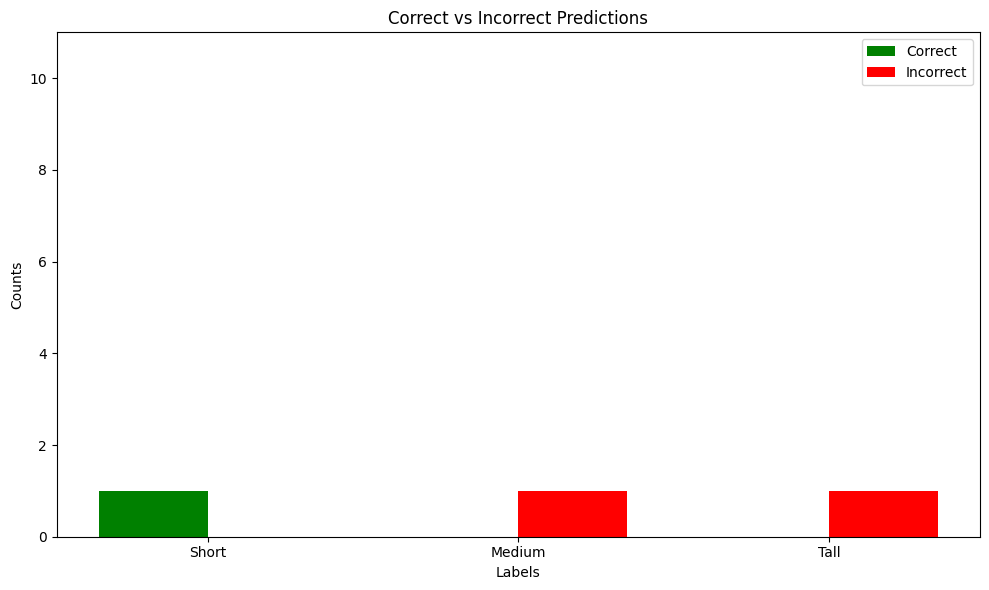

Class distribution (top data): {0: 5, 1: 3, 2: 3}
Class distribution (training data): {0: 4, 1: 2, 2: 2}
Class distribution (test data): {0: 1, 1: 1, 2: 1}
Training fold 1...
Fold 1 accuracy: 0.6667
Training fold 2...


/home/ec2-user/SageMaker/growy-kernel/miniconda/envs/growy_kernel/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Fold 2 accuracy: 0.3333
Training fold 3...
Fold 3 accuracy: 0.5000
Mean cross-validation accuracy: 0.5000
Test set accuracy: 0.6667
Confusion Matrix:
[[1 0 0]
 [1 0 0]
 [0 0 1]]
Classification Report:
              precision    recall  f1-score   support

       Short       0.50      1.00      0.67         1
      Medium       0.00      0.00      0.00         1
        Tall       1.00      1.00      1.00         1

    accuracy                           0.67         3
   macro avg       0.50      0.67      0.56         3
weighted avg       0.50      0.67      0.56         3



/home/ec2-user/SageMaker/growy-kernel/miniconda/envs/growy_kernel/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/SageMaker/growy-kernel/miniconda/envs/growy_kernel/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/SageMaker/growy-kernel/miniconda/envs/growy_kernel/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

<Figure size 1000x700 with 0 Axes>

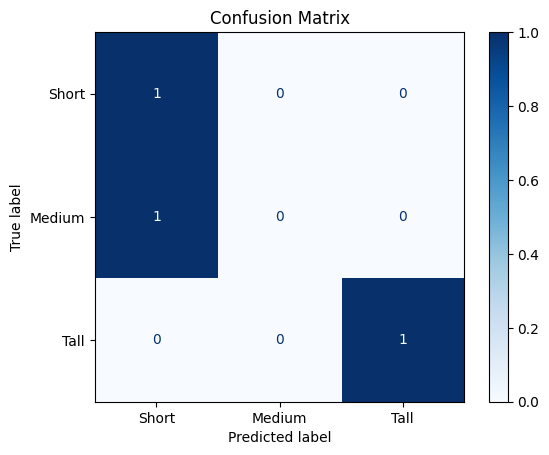

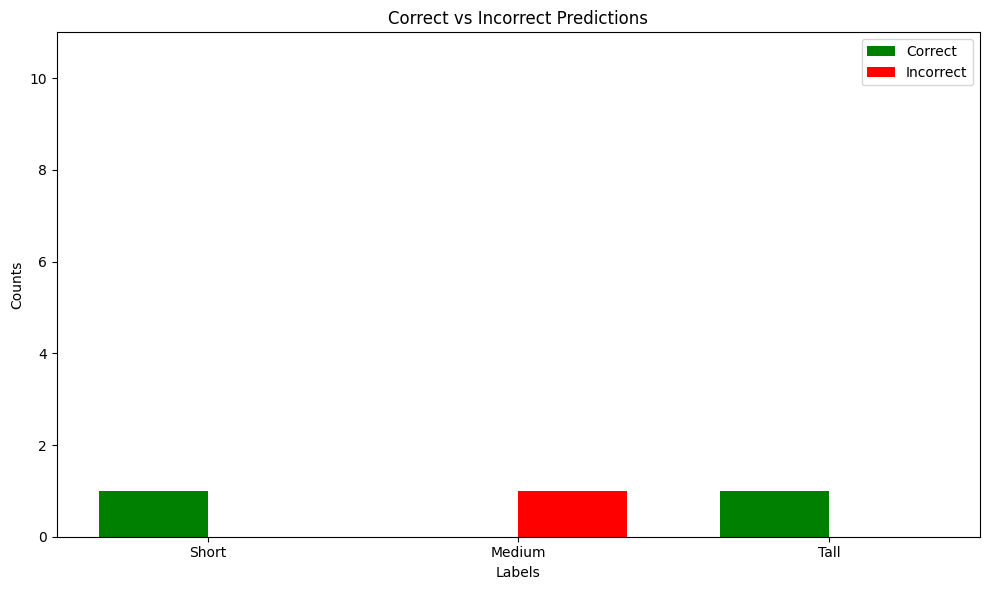

In [6]:
# Common imports
import os
import numpy as np
import cv2
import pandas as pd
import json
from skimage.feature import hog
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
import matplotlib.pyplot as plt
from skimage import exposure
import concurrent.futures
import pickle
from imblearn.ensemble import BalancedRandomForestClassifier

# Common paths and model save paths
image_folders = {
    'side': 'brispi/side_images',
    'top': 'brispi/top_images'
}
height_folder = 'height_arrays'
model_save_paths = {
    'side': 'demo_results/demo_RF_3class_side/demo_RF_3class_side_model.pkl',
    'top': 'demo_results/demo_RF_3class_top/demo_RF_3class_top_model.pkl'
}
results_save_paths = {
    'side': 'demo_results/demo_RF_3class_side/cv_results.csv',
    'top': 'demo_results/demo_RF_3class_top/cv_results.csv'
}
plot_save_paths = {
    'side': 'demo_results/demo_RF_3class_side/confusion_matrix.png',
    'top': 'demo_results/demo_RF_3class_top/confusion_matrix.png'
}
test_results_paths = {
    'side': 'demo_results/demo_RF_3class_side/test_results.json',
    'top': 'demo_results/demo_RF_3class_top/test_results.json'
}
metrics_save_paths = {
    'side': 'demo_results/demo_RF_3class_side/metrics.json',
    'top': 'demo_results/demo_RF_3class_top/metrics.json'
}
bar_plot_save_paths = {
    'side': 'demo_results/demo_RF_3class_side/actual_vs_predicted_bar_plot.png',
    'top': 'demo_results/demo_RF_3class_top/actual_vs_predicted_bar_plot.png'
}

# Ensure that the output directories exist
for path in model_save_paths.values():
    os.makedirs(os.path.dirname(path), exist_ok=True)

# Best hyperparameters
best_params = {
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'trim_bottom': 0.08805012610937063,
    'trim_top': 0.2893423891188367,
    'short_threshold': 748,
    'tall_threshold': 1205
}

# Common Functions
def split_filename(filename):
    parts = filename.split("_")
    base = "_".join(parts[:5])
    z = "_".join(parts[5:7])
    y_m_d_h = "_".join(parts[8:12])
    y_m_d, h = y_m_d_h.split("_")[0:3], y_m_d_h.split("_")[-1]
    min_sec = "_".join(parts[12:])
    return base, z, y_m_d, min_sec, h

def get_files_and_splits(directory):
    files = os.listdir(directory)
    return [split_filename(f) + (f,) for f in files]

def hours_within_threshold(hour1, hour2, threshold=1):
    hour1, hour2 = int(hour1), int(hour2)
    return (hour1 == hour2) or ((hour1 + 1) % 24 == hour2) or ((hour1 - 1) % 24 == hour2)

def calculate_trimmed_mean(height_array, trim_bottom, trim_top):
    sorted_height_array = np.sort(height_array)
    lower_bound = int(trim_bottom * len(sorted_height_array))
    upper_bound = int((1 - trim_top) * len(sorted_height_array))
    
    if trim_bottom + trim_top >= 1.0:
        raise ValueError("The sum of trim_bottom and trim_top must be less than 1.0")
    
    trimmed_array = sorted_height_array[lower_bound:upper_bound]
    trimmed_mean = np.mean(trimmed_array)
    
    return trimmed_mean

def load_image_and_height(match, image_type, trim_bottom, trim_top):
    if image_type == 'side':
        img_file = match + '.jpg'
        height_file = match + '.npy'
    else:
        top_image_name, height_array_name = match
        img_file = top_image_name
        height_file = height_array_name
    
    img_path = os.path.join(image_folders[image_type], img_file)
    height_path = os.path.join(height_folder, height_file)

    if not os.path.exists(img_path):
        print(f"Image file does not exist: {img_path}")
        return None, None

    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load image: {img_path}")
        return None, None
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if image_type == 'top':
        img = cv2.rotate(img, cv2.ROTATE_180)
    height, width = img.shape[:2]
    start_x = (width - 3280) // 2
    start_y = (height - 2464) // 2
    img = img[start_y:start_y + 2464, start_x:start_x + 3280]
    img = cv2.resize(img, (224, 224))

    height_array = np.load(height_path)
    if height_array.size == 0:
        print(f"Height array is empty: {height_path}")
        return None, None

    mean_height = calculate_trimmed_mean(height_array, trim_bottom, trim_top)
    return img, mean_height

def preprocess_data(image_type, trim_bottom, trim_top):
    if image_type == 'side':
        matches = [f.replace('.jpg', '') for f in os.listdir(image_folders[image_type]) if f.endswith('.jpg')]
    else:
        image_files = get_files_and_splits(image_folders[image_type])
        array_files = get_files_and_splits(height_folder)
        matches = [(image[-1], array[-1]) for image in image_files for array in array_files
                   if image[0] == array[0] and image[2] == array[2] and hours_within_threshold(image[4], array[4])]
    
    images, mean_heights = [], []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(lambda match: load_image_and_height(match, image_type, trim_bottom, trim_top), matches))
    for img, mean_height in results:
        if img is not None and mean_height is not None:
            images.append(img)
            mean_heights.append(mean_height)
    return np.array(images), np.array(mean_heights)

def custom_preprocessing(img):
    img = np.array(img)
    for channel in range(img.shape[2]):
        img[..., channel] = exposure.rescale_intensity(img[..., channel], out_range=(0, 1))
        img[..., channel] = exposure.equalize_hist(img[..., channel])
        img[..., channel] = exposure.equalize_adapthist(img[..., channel], clip_limit=0.03)
    return img

def label_height_array(mean_height, short_threshold, tall_threshold):
    if mean_height < short_threshold:
        return 'Short'
    elif mean_height > tall_threshold:
        return 'Tall'
    else:
        return 'Medium'

def extract_hog_features(image):
    gray_image = (image * 255).astype(np.uint8)  # Convert to 8-bit unsigned integer
    gray_image = cv2.cvtColor(gray_image, cv2.COLOR_RGB2GRAY)
    fd, hog_image = hog(gray_image, orientations=8, pixels_per_cell=(16, 16),
                cells_per_block=(1, 1), visualize=True)
    return fd, hog_image

def plot_bar(y_true, y_pred, label_map, plot_save_path):
    unique_labels = list(label_map.values())
    correct_counts = [np.sum((y_true == label) & (y_pred == label)) for label in unique_labels]
    incorrect_counts = [np.sum((y_true == label) & (y_pred != label)) for label in unique_labels]

    bar_width = 0.35
    index = np.arange(len(unique_labels))

    plt.figure(figsize=(10, 6))
    plt.bar(index, correct_counts, bar_width, label='Correct', color='g')
    plt.bar(index + bar_width, incorrect_counts, bar_width, label='Incorrect', color='r')

    plt.xlabel('Labels')
    plt.ylabel('Counts')
    plt.title('Correct vs Incorrect Predictions')
    plt.xticks(index + bar_width / 2, list(label_map.keys()))
    plt.ylim(0, max(max(correct_counts), max(incorrect_counts)) + 10)  # Ensure y-axis starts at 0
    plt.legend()
    plt.tight_layout()
    plt.savefig(plot_save_path)
    plt.show()

# Function to train and evaluate the model
def train_and_evaluate_model(image_type='side'):
    # Select paths based on image type
    image_folder = image_folders[image_type]
    model_save_path = model_save_paths[image_type]
    results_save_path = results_save_paths[image_type]
    plot_save_path = plot_save_paths[image_type]
    test_results_path = test_results_paths[image_type]
    metrics_save_path = metrics_save_paths[image_type]
    bar_plot_save_path = bar_plot_save_paths[image_type]

    # Preprocess data
    images, mean_heights = preprocess_data(image_type, best_params['trim_bottom'], best_params['trim_top'])
    if len(images) == 0 or len(mean_heights) == 0:
        raise ValueError("No images or height arrays were loaded. Please check the data folder and files.")

    images = images / 255.0

    labels = np.array([label_height_array(mean_height, best_params['short_threshold'], best_params['tall_threshold']) for mean_height in mean_heights])
    label_map = {'Short': 0, 'Medium': 1, 'Tall': 2}
    numerical_labels = np.array([label_map[label] for label in labels])

    # Check class distribution
    unique, counts = np.unique(numerical_labels, return_counts=True)
    class_distribution = dict(zip(unique, counts))
    print(f"Class distribution ({image_type} data):", class_distribution)

    # Extract HOG features
    hog_features, hog_images = zip(*[extract_hog_features(img) for img in images])
    hog_features = np.array(hog_features)

    # Ensure test set has one image from each class
    test_indices = []
    for class_label in np.unique(numerical_labels):
        class_indices = np.where(numerical_labels == class_label)[0]
        np.random.shuffle(class_indices)
        test_indices.append(class_indices[0])
    
    # The rest will be used for training
    train_indices = list(set(range(len(numerical_labels))) - set(test_indices))
    
    X_train = np.array([hog_features[i] for i in train_indices])
    y_train = np.array([numerical_labels[i] for i in train_indices])
    X_test = np.array([hog_features[i] for i in test_indices])
    y_test = np.array([numerical_labels[i] for i in test_indices])

    # Check class distribution in training and test sets
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    class_distribution_train = dict(zip(unique_train, counts_train))
    print(f"Class distribution (training data):", class_distribution_train)

    unique_test, counts_test = np.unique(y_test, return_counts=True)
    class_distribution_test = dict(zip(unique_test, counts_test))
    print(f"Class distribution (test data):", class_distribution_test)

    # 3-fold cross-validation setup on training data for small datasets
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    fold = 1
    cv_results = []
    fold_metrics = []

    for train_index, val_index in kf.split(X_train, y_train):
        print(f"Training fold {fold}...")
        X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
        y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

        model = BalancedRandomForestClassifier(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            min_samples_split=best_params['min_samples_split'],
            min_samples_leaf=best_params['min_samples_leaf'],
            sampling_strategy='all',
            replacement=True,
            bootstrap=False,
            random_state=42
        )

        model.fit(X_train_cv, y_train_cv)
        y_pred_val = model.predict(X_val_cv)
        accuracy_val = accuracy_score(y_val_cv, y_pred_val)
        fold_results = {
            'fold': fold,
            'accuracy': accuracy_val
        }
        cv_results.append(accuracy_val)
        fold_metrics.append(fold_results)
        print(f"Fold {fold} accuracy: {accuracy_val:.4f}")
        fold += 1

    mean_cv_accuracy = np.mean(cv_results)
    print(f"Mean cross-validation accuracy: {mean_cv_accuracy:.4f}")

    # Save cross-validation results
    cv_results_dict = {
        'fold_accuracies': cv_results,
        'mean_cv_accuracy': mean_cv_accuracy
    }
    pd.DataFrame(cv_results_dict).to_csv(results_save_path, index=False)

    # Fit final model on all training data
    final_model = BalancedRandomForestClassifier(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        sampling_strategy='all',
        replacement=True,
        bootstrap=False,
        random_state=42
    )
    final_model.fit(X_train, y_train)

    # Save the model
    with open(model_save_path, 'wb') as f:
        pickle.dump(final_model, f)

    # Evaluate the final model on the test set
    y_pred_test = final_model.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    class_report = classification_report(y_test, y_pred_test, target_names=['Short', 'Medium', 'Tall'])

    print(f'Test set accuracy: {accuracy_test:.4f}')
    print('Confusion Matrix:')
    print(conf_matrix)
    print('Classification Report:')
    print(class_report)

    # Save metrics
    metrics = {
        'accuracy': accuracy_test,
        'confusion_matrix': conf_matrix.tolist(),
        'classification_report': class_report
    }
    with open(metrics_save_path, 'w') as f:
        json.dump(metrics, f, indent=4)

    # Save prediction results
    test_results_dict = {
        'y_test': y_test.tolist(),
        'y_pred_test': y_pred_test.tolist()
    }
    with open(test_results_path, 'w') as f:
        json.dump(test_results_dict, f)

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Short', 'Medium', 'Tall'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.savefig(plot_save_path)
    plt.show()

    # Plot bar plot of actual vs. predicted labels
    plot_bar(y_test, y_pred_test, label_map, bar_plot_save_path)

# Run the model for side images
train_and_evaluate_model('side')

# Run the model for top images
train_and_evaluate_model('top')